# Fastai Implementation of Full-Resolution Resdual Networks (FRRN) for Semantic Segmentation in Street Scenes
---
Link to paper on [arxiv](https://arxiv.org/abs/1611.08323)

In [1]:
from fastai2.vision.all import *

## Data

In [2]:
path = untar_data(URLs.CAMVID)
Path.BASE_PATH = path
path.ls()

(#5) [Path('codes.txt'),Path('images'),Path('valid.txt'),Path('models'),Path('labels')]

In [3]:
codes = np.loadtxt(path/'codes.txt', dtype=str)
codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car',
       'CartLuggagePram', 'Child', 'Column_Pole', 'Fence', 'LaneMkgsDriv',
       'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving',
       'ParkingBlock', 'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk',
       'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel',
       'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [4]:
valid_files = (path/'valid.txt').read().split('\n')
len(valid_files)

102

In [5]:
def ListSplitter(valid_files):
    """
    Split images into training and validation set using the list of validation files provided
    """
    def _inner(files):
        val_mask = tensor([o in valid_files for o in files])
        return ~val_mask, val_mask
    return _inner

In [6]:
def get_y(file):
    """
    Get the path to the mask for a particular image
    """
    return path/'labels'/f'{file.stem}_P{file.suffix}'

In [7]:
dblock = DataBlock(
    blocks=(ImageBlock, MaskBlock(codes=codes)),
    get_items=get_image_files,
    splitter=ListSplitter(valid_files),
    get_y=get_y,
    batch_tfms=[*aug_transforms(size=(360, 480)), Normalize()])

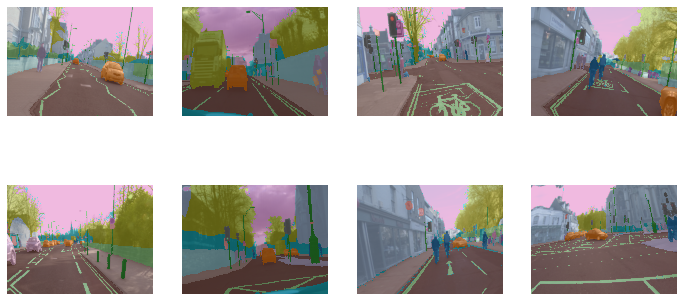

In [8]:
dls = dblock.dataloaders(path/'images', bs=8)
dls.show_batch()

In [87]:
dls.vocab = codes

## FRRN Implementation
---
An FRRN is composed of a sequence of full-resolution residual units (FRRUs).

### FRRU Module

![ffru design](frru.png)

In [81]:
class FRRU(Module):
    def __init__(self, psc, rsc, scale, nf):
        """
        psc= number of channels in pooling stream input
        rsc= number of channels in residual stream input
        """
        self.mp = nn.MaxPool2d(scale, scale)
        self.conv1 = ConvLayer(psc+rsc, nf)
        self.conv2 = ConvLayer(nf, nf)
        self.res_conv = ConvLayer(nf, rsc, ks=1, bias=True, norm_type=None, act_cls=None)
        
    def forward(self, inp):
        y, z = inp
        x = torch.cat([y, self.mp(z)], dim=1)
        y_n = self.conv2(self.conv1(x)) # output for the pooling stream
        # output for the residual stream
        x = F.interpolate(self.res_conv(y_n), size=z.shape[-2:],
                            mode='nearest')
        z_n = z + x
        
        return y_n, z_n

The authors of the paper designed two FRRN architectures to assess their approach’s segmentation performance. Depending on the input image resolution, they use FRRN A or FRRN B to keep the relative size of the receptive fields consistent.

In [82]:
frrn_specs = {
    'a': {'encoder': [[2,3,96], [4,4,192], 
                      [8,2,384], [16,2,384]],
          'decoder': [[8,2,192], [4,2,192],[2,2,96]]
    },
    'b': {'encoder': [[2,3,96], [4,4,192], [8,2,384],
                      [16,2,384], [32,2,384]],
          'decoder': [[16,2,192], [8,2,192], 
                      [4,2,192], [2,2,96]]
    }
}

Each `[x,y,z]` pair is the *scale* (how much the residual input needs to be scaled in order to match the corresponding pooling stream input), *the number of ffru's and the number of output feature maps* for a particular block in the network.

In [91]:
class FRRUBlock(nn.Sequential):
    def __init__(self, psc, rsc, scale, ns, nf):
        layers = []
        for _ in range(ns):
            layers.append(FRRU(psc, rsc, scale, nf))
            psc=nf
        
        super().__init__(*layers)

In [92]:
class FRRN(Module):
    def __init__(self, n_classes, arch='a', n_in=3):
        frrn = frrn_specs[arch]
        
        # the first two layers are the same for each type of architecture
        ru = [ResBlock(1,48,48 ) for _ in range(3)]
        self.stem = nn.Sequential(ConvLayer(3, 48, ks=5), *ru)
        
        psc, rsc = 48, 32
        self.encoder = []
        for specs in frrn['encoder']:
            block = FRRUBlock(psc, rsc, *specs)
            self.encoder.append(block)
            psc = specs[2]

        self.decoder = []
        for specs in frrn['decoder']:
            block = FRRUBlock(psc, rsc, *specs)
            self.decoder.append(block)
            psc = specs[2]
            
        ru = [ResBlock(1,48,48 ) for _ in range(2)]
        self.head = nn.Sequential(
            ResBlock(1,psc+rsc,48),
            *ru,
            ConvLayer(48,n_classes,ks=1,bias=True,norm_type=None,act_cls=None))
        
        self.mp = nn.MaxPool2d(2,2)
        self.res_conv = ConvLayer(48, 32, ks=1, norm_type=None, act_cls=None)
        
    def forward(self, x):
        x = self.stem(x)
        y = x # pooling stream
        z = self.res_conv(x) # residual stream
        
        # forward pass through encoder
        for block in self.encoder:
            y = self.mp(y) # max pool
            y, z = block((y,z))
            
        # forward pass through decoder
        for block in self.decoder:
            y = F.interpolate(y, scale_factor=2, 
                              mode='bilinear') # unpool
            y, z = block((y,z))
        
        y = F.interpolate(y, scale_factor=2, 
                              mode='bilinear') # unpool
        # concatenate
        x = torch.cat([y,z], dim=1)
        x = self.head(x)
        return x
            

## Train the model

Define accuracy metric for camvid

In [93]:
val2idx = L([code for code in codes]).val2idx()
void_code = val2idx['Void']
void_code

30

In [94]:
def acc_camvid(pred, targ):
    mask = targ != void_code
    return (pred.argmax(dim=1)[mask] == targ[mask]).float().mean()

In [97]:
model = FRRN(get_c(dls))
model = model.cuda()

In [99]:
learn = Learner(dls, model, metrics=acc_camvid)

In [100]:
learn.lr_find()

RuntimeError: CUDA out of memory. Tried to allocate 254.00 MiB (GPU 0; 7.94 GiB total capacity; 7.31 GiB already allocated; 108.00 MiB free; 7.38 GiB reserved in total by PyTorch)